<a id="top"></a>
 <font size="5">BAPC</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import pitsa_lite as pitsa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Input

In [9]:
csv_file = '1_step'
#csv_file = '2_ramp'

base_model_name = 'Sklearn-Model'
#correction_model_name = 'KNN' # fast but less accurate forecast. Set return_lime = False in this case
correction_model_name = 'LSTM' # slow but more accurate forecast

# meta parameters
forecast_lenght = 0 # forecast lenght

# Folders

In [10]:
# Please enter the input data folder 
data_folder = '../../../2_data/processed/synthetic'

# Please enter the output figure folder
fig_base = '../../../4_results/figures'

# save the figures ?
save_fig = True

# current convention
notebook_name, _  = os.path.splitext(os.path.basename(globals()['__vsc_ipynb_file__']))
fig_folder = os.path.join(fig_base, notebook_name)

if save_fig and not os.path.exists(fig_folder):
    print('Folder {} was created'.format(fig_folder))
    os.mkdir(fig_folder)

# Data

Figure ../../../4_results/figures\2_5_bapc_window\1_step_win_data.png was saved


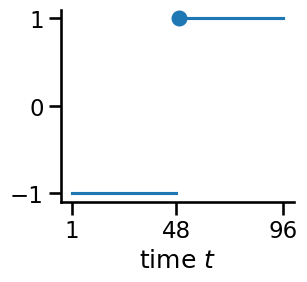

In [11]:
# time series reading
file_name = os.path.join(data_folder, csv_file + '.csv')
df = pd.read_csv(file_name, index_col='t')
df.reset_index(drop=True, inplace=True)

# plot
tast = 48
t = df.index.values
n_train = df.shape[0]


with sns.plotting_context("talk"):

    f, ax = plt.subplots(figsize=(3, 2.5))
        
    if csv_file == '1_step':
        ax.plot(t[:tast], df['y'].loc[:tast-1], color='tab:blue')
        ax.plot(t[tast:], df['y'].loc[tast:], color='tab:blue', label=r'$y$')
        ax.scatter(tast, df['y'].loc[tast], color='tab:blue', s=100)
    elif csv_file == '2_ramp':
        ax.plot(t, df['y'], color='tab:blue', label=r'$y$')

    xticks = np.array([0, tast-1, n_train-1])
    ax.set_xticks(xticks, labels=xticks+1)
    plt.locator_params(axis='y', nbins=3)
    ax.set_xlabel(r'time $t$')
    ax.set_ylabel('')
    sns.despine()

    xlim = ax.get_xlim() # to be reused later

    if save_fig:
        fig_name = os.path.join(fig_folder, '{}_win_data.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure {} was saved'.format(fig_name))

# Base model

In [12]:
if base_model_name == 'Sklearn-Model':
    if csv_file == '1_step':
        model = DummyRegressor(strategy="mean")
        base_model = pitsa.models.regression.SKLearnModel(model=model)
        cols = ['intercept']
    elif csv_file == '2_ramp':
        model = LinearRegression(fit_intercept=True)
        base_model = pitsa.models.regression.SKLearnModel(model=model)
        cols = ['intercept', 'slope']
    else:
        raise ValueError('Model {} is not included'.format(csv_file))
else:
    error_msg = 'Model {} is not instantiated. Use this place to instantiate your new base model'.format(base_model_name)
    raise ValueError(error_msg)

# Correction model

In [13]:
if correction_model_name == 'KNN':
    model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
    correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')
    correction_model.ar_order = 0
elif correction_model_name == 'LSTM':
    fit_args={'epochs':400, 'verbose':0}
    ar_order = 12
    SEED = 2022
    correction_model = pitsa.models.timeseries.RNN(model=None, ar_order=ar_order, fit_args=fit_args, name='LSTM')
    correction_model.initialize(lstm_units=16, SEED=SEED)

# BAPC

In [14]:
parameters, explainers = pitsa.experimenter.run.run_sbapc(df=df,
                                                          base_model=base_model, 
                                                          correction_model=correction_model, 
                                                          n_train=n_train,
                                                          forecast_lenght=forecast_lenght)

Figure ../../../4_results/figures\2_5_bapc_window\1_step_win_bapc.png was saved


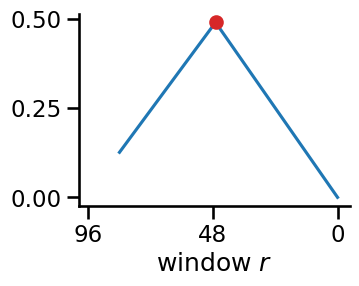

In [15]:
look_backs = list(explainers['y'][n_train-1].keys())
data = []
t = df.index[-1]

for look_back in look_backs:

    components = explainers['y'][n_train-1][look_back]
    explanation, importance = pitsa.xai.importance.explain_ig(components, t)
    importance['r'] = look_back
    data.append(importance[['r']+cols])

results = pd.concat(data)
results['sum'] = results[cols].sum(axis=1)

with sns.plotting_context("talk"):
    
    f, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.plot(results['r'], results['sum'], color='tab:blue', label='sum')

    rticks = [0, 48, 96]
    ropt = results.set_index('r')['sum'].argmax()
    
    ax.set_xlabel(r'window $r$')
    ax.set_xticks(rticks, labels=rticks)
    ax.set_xlim(xlim)
    
    ax.scatter(results['r'].iloc[ropt], results['sum'].iloc[ropt], color='tab:red', zorder=5)
    
    ax.invert_xaxis()
    ax.set_ylabel('')
    sns.despine()

    if csv_file == '1_step':
        yticks = [0.0, 0.25, 0.5]
        ax.set_yticks(yticks, labels=['{:.2f}'.format(y) for y in yticks])
    elif csv_file == '2_ramp':
        yticks = [0, 5, 7.5, 10]
        ax.set_yticks(yticks, labels=yticks)
        ax.yaxis.get_major_ticks()[2].set_visible(False)

    if save_fig:
        fig_name = os.path.join(fig_folder, '{}_win_bapc.png'.format(csv_file))
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
        print('Figure {} was saved'.format(fig_name))

# Bottom